# Quasi-Newton's method by RSFs 

In this notebook, we illustrate a use of RSF-based estimators for $\mathsf{K}\mathbf{y}$. In this case, we look at the following problem where the data fidelity term is a convex, differentiable function $f_{\mathbf{y},q}:\mathbb{R}^{n}\rightarrow\mathbb{R}$:

$$
    \mathbf{x}^* = \arg\min_{x\in\mathbb{R}^{n}} L(\mathbf{x}),
$$
where the loss function $L$ reads: 
$$
    L(x) = f_{\mathbf{y},q}(\mathbf{x}) + \frac{1}{2}\mathbf{x}^\top\mathsf{L}\mathbf{x}.
$$

Newton's method gives the following iteration for approximating $\mathbf{x}^*$:
$$
    \mathbf{x}_{k+1} =\mathbf{x}_{k} -\alpha \mathsf{H}^{-1}\nabla L(\mathbf{x}),
$$
where $\nabla$ is the gradient operator and $\mathsf{H}$ is the Hessian matrix (matrix of partial derivatives) of $L(x)$ that verifies:
$$
    \mathsf{H}=\left[\frac{\partial^2 L(\mathbf{x})}{\partial{x_i}\partial {x_j}}\right]_{i,j}
$$

Assume $\frac{\partial^2 L(\mathbf{x})}{\partial{x_i}\partial {x_j}} = 0$ for all $i\not=j$ and collect the non-zero second derivatives into a vector $\mathbf{g}=\left[\frac{\partial^2 L(\mathbf{x})}{\partial{x_i}^2} \right]_i \in \mathbb{R}^{n}$. One recovers the regularized Laplacian as the Hessian matrix: 

$$
    \mathsf{H} = \mathsf{L} + \text{diag}(\mathbf{g})
$$

and the gradient becomes: 

$$
  \nabla L(\mathbf{x}) = \mathsf{L}\mathbf{x} + \mathbf{h},
$$

where $\mathbf{h}=\left[\frac{\partial L(\mathbf{x})}{\partial{x_i}}\right]_i$ collects the first derivatives. As a result, one needs to compute the regularized inverse $\mathsf{H}^{-1}\nabla L(\mathbf{x})$ which can be efficiently done by RSF-based estimators.


In [1]:
using RandomForests

[ Info: Precompiling RandomForests [e81499c0-f9dc-443f-84b6-a65cdedd22fa]


In [2]:
using Graphs
using StatsBase
using Distributions
using SparseArrays
using LinearAlgebra
using PoissonRandom
using PyPlot

In [3]:
using TestImages, ImageQualityIndexes,Images

## Poisson Model
Here in this example, we assume the noisy image is generated by the Poisson model: 
$$ 
    \mathbf{y} \sim \text{Poisson}(\exp(\mathbf{x})) 
$$
where $\exp$ is the element-wise exponential function. Poisson model is a popular choice in image processing as it naturally models the shot noise of a camera. Having this as the likelihood function, we choose to use a log-likelihood function for $f_{\mathbf{y},q}$ which takes the following form: 
$$
    f_{\mathbf{y},q} = q \sum_{i=1}^n \exp(x_i) - y_i x_i 
$$

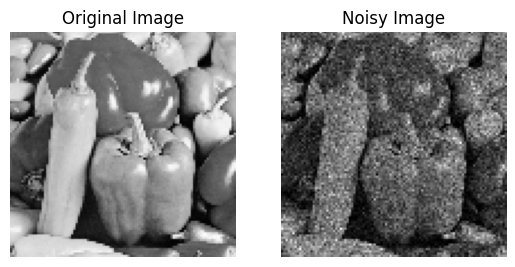

(-0.5, 99.5, 99.5, -0.5)

In [4]:
imname = "peppers"
image = Gray.(imresize(testimage(imname),100,100))
rescale = 25.0

nx = size(image,1)
ny = size(image,2)
rs = (v) -> reshape(v,nx,ny)
G = Graphs.grid([nx,ny])
scaledimage = (rescale .* Float64.(image))
im_noisy = pois_rand.(scaledimage)
im_noisy .= Int64.(im_noisy)

subplot(1,2,1)
title("Original Image")
imshow(Float64.(image),cmap="gray")
axis("off")
subplot(1,2,2)
title("Noisy Image")
imshow(im_noisy./rescale,cmap="gray")
axis("off")

In [5]:
x = zeros(size(image))
xtilde = zeros(size(image))
xbar = zeros(size(image))
y = im_noisy
y = y[:]

z0 = (rand(nv(G)))
mu = 0.1
nrep = 10
maxiter = 100
tol = 10^(-10)

1.0e-10

In [6]:
# A helper function to compute constant part of the loss function
function logfact(y)
    res = 0
    for i = 1 : y
        res += log(i)
    end
    res
end
logysum = sum(logfact.(y))

213266.5372516797

## Newton's update
Then, Newton's iteration for solving the optimization problem becomes: 
$$
    \mathbf{x}_{k+1} = \mathbf{x}_{k} - \alpha (\mathsf{L} + \mathsf{Q})^{-1}\mathsf{Q}\mathbf{y}'_k
$$
with 
$$
    \mathsf{Q} = q\text{ diag}(\exp(\mathbf{x}_k)) \\ 
    \forall i\in \mathcal{V}, \quad \mathbf{y}'_i =  \frac{(\mathsf{L}\mathbf{x})_i + q(\exp(x_i) - y_i)}{q\exp(x_i)} 
$$
This derivation shows that one needs to compute this regularized inverse at every iteration which can be approximated by RSF-based estimators. The following function implements this iteration for the exact and forest-based updates.

In [7]:
t = @elapsed xhat,increment_hat,loss_hat = newton_poisson_noise(G,y,z0,mu;numofiter = maxiter,tol=tol, method="exact")
display("Completed in $t secs")

Iteration=0, ||t_k - t_{k+1}||^2=57.780858510888386, alpha=0.1
Iteration=1, ||t_k - t_{k+1}||^2=159.48889612574527, alpha=0.25
Iteration=2, ||t_k - t_{k+1}||^2=29.67491701365079, alpha=0.5
Iteration=3, ||t_k - t_{k+1}||^2=9.121626702441024, alpha=0.5
Iteration=4, ||t_k - t_{k+1}||^2=3.984170450190693, alpha=0.5
Iteration=5, ||t_k - t_{k+1}||^2=1.8802981749208878, alpha=0.5
Iteration=6, ||t_k - t_{k+1}||^2=0.9151688535808596, alpha=0.5
Iteration=7, ||t_k - t_{k+1}||^2=0.45166452171408245, alpha=0.5
Iteration=8, ||t_k - t_{k+1}||^2=0.22439051913799307, alpha=0.5
Iteration=9, ||t_k - t_{k+1}||^2=0.11183946439677217, alpha=0.5
Iteration=10, ||t_k - t_{k+1}||^2=0.05583135507684987, alpha=0.5
Iteration=11, ||t_k - t_{k+1}||^2=0.027893654204344937, alpha=0.5
Iteration=12, ||t_k - t_{k+1}||^2=0.013941330105204196, alpha=0.5
Iteration=13, ||t_k - t_{k+1}||^2=0.006969291905954821, alpha=0.5
Iteration=14, ||t_k - t_{k+1}||^2=0.0034843028040168838, alpha=0.5
Iteration=15, ||t_k - t_{k+1}||^2=0.003

"Completed in 1241.637454784 secs"

In [8]:
t = @elapsed xtilde,increment_tilde,loss_tilde = newton_poisson_noise(G,y,z0,mu;numofiter = maxiter,tol=tol, method="xtilde",nrep=nrep)
display("Completed in $t secs")

Iteration=0, ||t_k - t_{k+1}||^2=57.780858510888386, alpha=0.1
Iteration=1, ||t_k - t_{k+1}||^2=86.5129913711386, alpha=0.125
Iteration=2, ||t_k - t_{k+1}||^2=39.548220635374705, alpha=0.125
Iteration=3, ||t_k - t_{k+1}||^2=55.3721264955477, alpha=0.25
Iteration=4, ||t_k - t_{k+1}||^2=32.45930329366441, alpha=0.25
Iteration=5, ||t_k - t_{k+1}||^2=26.312071497472854, alpha=0.25
Iteration=6, ||t_k - t_{k+1}||^2=10.962428516750004, alpha=0.125
Iteration=7, ||t_k - t_{k+1}||^2=16.090191379513506, alpha=0.25
Iteration=8, ||t_k - t_{k+1}||^2=8.070568546619528, alpha=0.0625
Iteration=9, ||t_k - t_{k+1}||^2=8.95481590023744, alpha=0.125
Iteration=10, ||t_k - t_{k+1}||^2=5.845994895280066, alpha=0.0625
Iteration=11, ||t_k - t_{k+1}||^2=7.09187367438066, alpha=0.125
Iteration=12, ||t_k - t_{k+1}||^2=6.738825308567337, alpha=0.125
Iteration=13, ||t_k - t_{k+1}||^2=5.492150438660859, alpha=0.125
Iteration=14, ||t_k - t_{k+1}||^2=3.766397090403906, alpha=0.03125
Iteration=15, ||t_k - t_{k+1}||^2=5.

"Completed in 1.034567673 secs"

In [9]:
t = @elapsed xbar,increment_bar,loss_bar = newton_poisson_noise(G,y,z0,mu;numofiter = maxiter,tol=tol, method="xbar",nrep=nrep)
display("Completed in $t secs")

Iteration=0, ||t_k - t_{k+1}||^2=57.780858510888386, alpha=0.1
Iteration=1, ||t_k - t_{k+1}||^2=160.5310119066245, alpha=0.25
Iteration=2, ||t_k - t_{k+1}||^2=33.33509178856033, alpha=0.5
Iteration=3, ||t_k - t_{k+1}||^2=12.703984809288709, alpha=0.5
Iteration=4, ||t_k - t_{k+1}||^2=6.835088827951595, alpha=0.5
Iteration=5, ||t_k - t_{k+1}||^2=3.955408339689029, alpha=0.5
Iteration=6, ||t_k - t_{k+1}||^2=2.3718551871816693, alpha=0.5
Iteration=7, ||t_k - t_{k+1}||^2=1.4430581235048956, alpha=0.5
Iteration=8, ||t_k - t_{k+1}||^2=0.8969925976250477, alpha=0.5
Iteration=9, ||t_k - t_{k+1}||^2=0.559146754435279, alpha=0.5
Iteration=10, ||t_k - t_{k+1}||^2=0.36211424335209386, alpha=0.5
Iteration=11, ||t_k - t_{k+1}||^2=0.26841590415369393, alpha=0.5
Iteration=12, ||t_k - t_{k+1}||^2=0.15636145296730639, alpha=0.5
Iteration=13, ||t_k - t_{k+1}||^2=0.09826800502709797, alpha=0.5
Iteration=14, ||t_k - t_{k+1}||^2=0.06814231865385019, alpha=0.5
Iteration=15, ||t_k - t_{k+1}||^2=0.0500183584752

"Completed in 3.110830348 secs"

The forest-based updates is much faster w.r.t. the exact updates even though they take more iterations for satisfying the convergence criteria. Both qualitative and quantitative results show they approximate updates can give highly accurate results in much shorter amount of time!! 

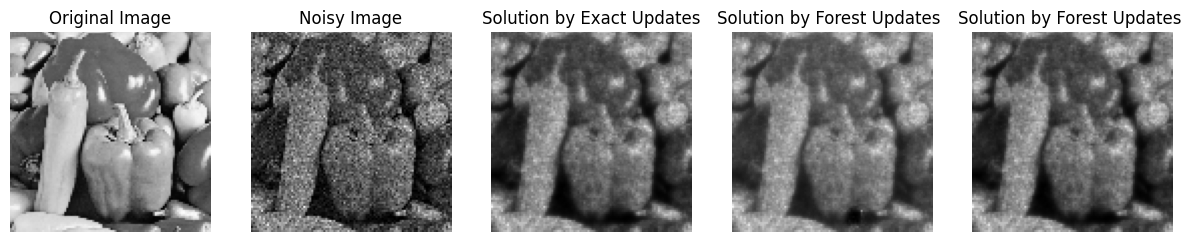

(-0.5, 99.5, 99.5, -0.5)

In [10]:
y = rs(y/rescale)
xhat = rs(xhat/rescale)
xtilde = rs(xtilde/rescale)
xbar = rs(xbar/rescale)

figure(figsize=[15,4])
subplot(1,5,1)
title("Original Image")
imshow(Float64.(image),cmap="gray")
axis("off")
subplot(1,5,2)
title("Noisy Image")
imshow(im_noisy./rescale,cmap="gray")
axis("off")
subplot(1,5,3)
title("Solution by Exact Updates")
imshow(Float64.(xhat),cmap="gray")
axis("off")
subplot(1,5,4)
title("Solution by Forest Updates ")
imshow(xtilde./rescale,cmap="gray")
axis("off")
subplot(1,5,5)
title("Solution by Forest Updates ")
imshow(xbar./rescale,cmap="gray")
axis("off")

In [11]:
noisy_psnr = (ImageQualityIndexes.assess_psnr(y, image))
xhat_psnr = (ImageQualityIndexes.assess_psnr(xhat, image))
xtilde_psnr = (ImageQualityIndexes.assess_psnr(xtilde, image))
xbar_psnr = (ImageQualityIndexes.assess_psnr(xbar, image))

display("y psnr: $noisy_psnr")
display("xhat psnr: $xhat_psnr")
display("xtilde psnr : $xtilde_psnr")
display("xbar psnr : $xbar_psnr")

"y psnr: 17.384165847464146"

"xhat psnr: 22.26589887507"

"xtilde psnr : 22.144826892133786"

"xbar psnr : 22.26589886523517"

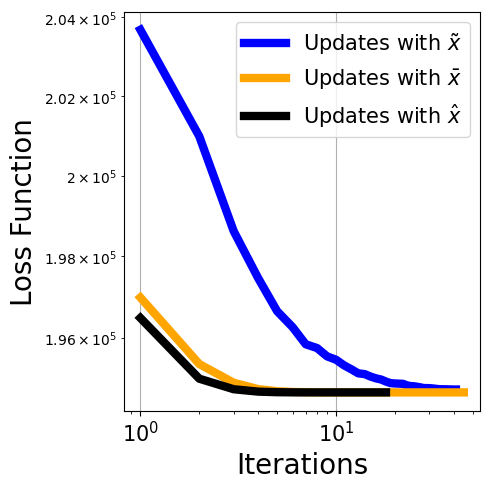

In [12]:
fig = figure(figsize=[5,5])
plot((1:length(loss_tilde)), loss_tilde .+ logysum, color="blue",linewidth=6.0, label="Updates with \$ \\tilde{x}\$")
plot((1:length(loss_bar)), loss_bar .+ logysum, color="orange",linewidth=6.0, label="Updates with \$ \\bar{x}\$")
plot((1:length(loss_hat)), loss_hat .+ logysum, color="black",linewidth=6.0, label="Updates with \$ \\hat{x}\$")
xlabel("Iterations",fontsize=20)
ylabel("Loss Function",fontsize=20)
xticks(fontsize=15)
yticks(fontsize=15)
PyPlot.grid(true)
xscale("log")
yscale("log")

legend(fontsize=15)
tight_layout()
